In [138]:
%matplotlib widget

from tqdm import trange
from matplotlib import cm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime, timezone, timedelta
import scipy.io
from matplotlib.colors import  Normalize

device = torch.device("cpu")



In [139]:

# Get the current time
current_time = datetime.now(timezone(timedelta(hours=1))).strftime("%Y-%m-%d_%H-%M")

# Create the folder
folder_name = os.path.join(os.getcwd(), current_time)

try:
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully!")
except FileExistsError:
    print(f"Folder '{folder_name}' already exists.")
except Exception as e:
    print(f"Error occurred while creating the folder: {e}")


Folder 'c:\Users\Wayne\Desktop\CUDI-contrast-ultrasound dispersion imaging\16_weekly_update_25022024\2024-02-26_19-41' created successfully!


In [140]:
A = 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                # initial displacment[mm]
SIGMA = 1 # std of initial push [mm]
CS = 2.0 # shear wave speed [mm/ms]
ETA = 1.5 # viscocity []
RHO = 0.001

RATIO = 1.5
TR_EPOCH = 1000
N_NEUROS = 64
# Optimisation parameters
x_range = [-20., 20.]    #[mm]
t_range = [0., 20.]      #[ms]
ic_samples = 200
xt_samples = 1000

prediction_interval = 1000

epochs = 100000
flag_epoch = 400000

In [141]:
class Net(nn.Module):
    def __init__(self, n_neurons=N_NEUROS, n_layers=4):
        super(Net, self).__init__()
        
        self.seq = torch.nn.Sequential()
        n_inputs = 2
        
        for i in range(n_layers):
            self.seq.add_module(f"lin_{i}", nn.Linear(n_inputs, n_neurons))
            n_inputs = n_neurons
            self.seq.add_module(f"tanh_{i}", nn.Tanh())
        
        self.seq.add_module(f"lin_{i+1}", nn.Linear(n_inputs, 1))
        
        # for module in self.seq:
        #     if isinstance(module, nn.Linear):
        #         torch.nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out', nonlinearity='tanh')
        for module in self.seq:
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_normal_(module.weight)
        
    def forward(self, x, t):        
        return self.seq(torch.cat([x, t], axis=1)) 


C:\Users\Wayne\AppData\Local\Temp\ipykernel_15004\488637189.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t_samples.detach().numpy(), x_samples.detach().numpy(), c='k', marker='.', alpha=0.2, label='Collocation points', cmap=cm.jet)
C:\Users\Wayne\AppData\Local\Temp\ipykernel_15004\488637189.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


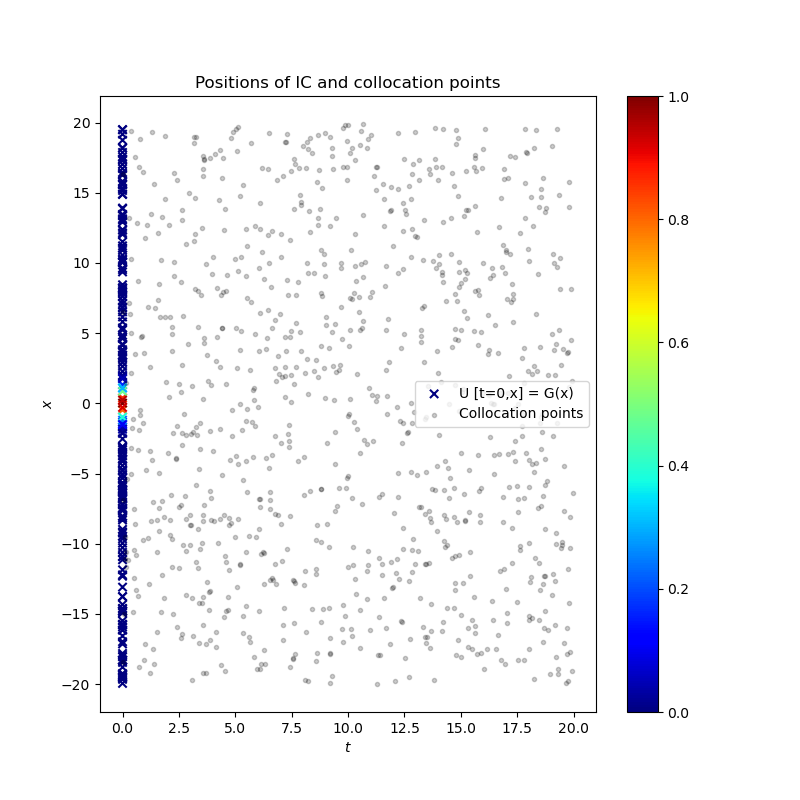

In [142]:

x_ic = torch.tensor(np.random.uniform(*x_range, (ic_samples, 1)), device=device, dtype=torch.float)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
u_ic = A * torch.exp(-1* (x_ic / SIGMA) ** 2)

epsilon = 1e-6

# x_samples = torch.tensor(np.random.uniform(*x_range, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
# t_samples = torch.tensor(np.random.uniform(*t_range, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)

x_samples = torch.tensor(np.random.uniform(x_range[0], x_range[1]-epsilon, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
t_samples = torch.tensor(np.random.uniform(t_range[0], t_range[1]-epsilon, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)


fig = plt.figure(figsize=(8,8))
# plt.scatter(t_bc.detach().numpy(), x_bc.detach().numpy(), c=u_bc.detach().numpy(), marker='^', vmin=0, vmax=20,label='U^[t,x = ±20] = 0',cmap=cm.jet)
plt.scatter(t_ic.detach().numpy(), x_ic.detach().numpy(), c=u_ic.detach().numpy(), marker='x', vmin=0, vmax=1, label='U [t=0,x] = G(x)', cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

plt.scatter(t_samples.detach().numpy(), x_samples.detach().numpy(), c='k', marker='.', alpha=0.2, label='Collocation points', cmap=cm.jet)

plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of IC and collocation points')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')
fig.savefig(os.path.join(folder_name, 'collocation points.png'))

In [143]:
def gaussian(x):
    return A*torch.exp(-1*(x/SIGMA)**2)

def window(t):
    return torch.tensor(((t >= 0) & (t <= 0.333)).float(), device=device)

def force(x,t):
    return gaussian(x)*window(t)


# init conditions
x_ic = torch.tensor(np.random.uniform(*x_range, (ic_samples, 1)), device=device, dtype=torch.float)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
u_ic = A * torch.exp(-1 * (x_ic / SIGMA) ** 2)


pinn = Net(n_neurons=N_NEUROS)
pinn = pinn.to(device)

mse_loss = torch.nn.MSELoss()
adam_optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)


# # pretraining
# losses = []
# for epoch in (pbar := trange(1000)):

#     # resample points each n epochs
#     if not epoch % 50:
#         x_samples = torch.tensor(np.random.uniform(*x_interval, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
#         t_samples = torch.tensor(np.random.uniform(*t_interval, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)

#     # pde loss
#     net_out = net(x_samples, t_samples)

#     net_out_u_x = torch.autograd.grad(net_out, x_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]
#     net_out_u_t = torch.autograd.grad(net_out, t_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]

#     net_out_u_xx = torch.autograd.grad(net_out_u_x, x_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]
#     net_out_u_tt = torch.autograd.grad(net_out_u_t, t_samples, grad_outputs=torch.ones(net_out.size()), create_graph=True)[0]

#     loss_pde = loss_fn(net_out_u_xx - (c**2 + eta * net_out_u_t) * net_out_u_tt, torch.zeros(net_out.size()))
#     losses.append(loss_pde.item())

#     loss_pde.backward()
#     optimizer.step()
#     optimizer.zero_grad()

#     if not epoch % 10:
#         pbar.set_description(f"Loss={loss_pde.item():.3e}")


selected_x_values = [4, 8, 12, 16]
num_test_samples = 500

losses = [[], [], []]
for epoch in (pbar := trange(epochs)):

    # resample points each n epochs
    if not epoch % TR_EPOCH:
        
        if epoch < flag_epoch:

            x_samples = torch.tensor(np.random.uniform(x_range[0], x_range[1]-epsilon, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
            t_samples = torch.tensor(np.random.uniform(t_range[0], t_range[1]-epsilon, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)

    # init conditions
    net_ic = pinn(x_ic, t_ic)
    net_dudt_ic = torch.autograd.grad(net_ic, t_ic, grad_outputs=torch.ones(net_ic.shape), create_graph=True)[0]
    loss_ic_u = mse_loss(net_ic, u_ic)
    loss_ic_dudt = mse_loss(net_dudt_ic, torch.zeros(net_ic.shape))

    # pde loss
    net_u = pinn(x_samples, t_samples)

    pred_u_x = torch.autograd.grad(net_u, x_samples, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
    pred_u_t = torch.autograd.grad(net_u, t_samples, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
    pred_u_xx = torch.autograd.grad(pred_u_x, x_samples, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
    pred_u_tt = torch.autograd.grad(pred_u_t, t_samples, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
    pred_u_xx_t = torch.autograd.grad(pred_u_xx, t_samples, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]

    # with viscocity
    # loss_pde = mse_loss(RHO*pred_u_tt - (RHO* CS**2 + ETA * pred_u_xx_t) * pred_u_xx , torch.zeros(net_u.size()))
    loss_pde = mse_loss(
        pred_u_tt - CS**2 * pred_u_xx - RATIO * pred_u_xx_t,
        torch.zeros(net_u.size()),
    )

    # Combining the loss functions
    loss = 1e0 * loss_ic_u + 1e0 * loss_ic_dudt + 1e0 * loss_pde 

    loss.backward()
    adam_optimizer.step()
    adam_optimizer.zero_grad()

    losses[0].append(loss_ic_u.item())
    losses[1].append(loss_ic_dudt.item())
    losses[2].append(loss_pde.item())

    if not epoch % 10:
        pbar.set_description(f"Loss={loss.item():.3e}")

    if epoch % prediction_interval == 0:
        # Create a single figure
        fig, ax = plt.subplots()

        # Plot u(t, x) for each selected x on the same graph
        for selected_x in selected_x_values:
            # Predict u(t, x) distribution for the fixed x
            t_flat = np.linspace(0, 20, num_test_samples)
            x_flat = np.full_like(t_flat, fill_value=selected_x)
            tx = np.stack([t_flat, x_flat], axis=-1)

            # Convert to torch tensors
            x_tensor = torch.from_numpy(tx[:, 1]).float().view(-1, 1)
            t_tensor = torch.from_numpy(tx[:, 0]).float().view(-1, 1)

            # Forward pass
            u = pinn(x_tensor, t_tensor).detach()

            # Move predicted values to CPU for plotting
            u = u.cpu().numpy()

            # Plot the result
            ax.plot(t_flat, u, label=f"u(t, x={selected_x})")

        ax.set_title(f"Prediction_epoch_{epoch}")
        ax.set_xlabel("Time (t) ")
        ax.set_ylabel("u(t, x)")
        ax.legend()

        # Save the image with a unique name
        image_name = f"Prediction_epoch_{epoch}.png"
        fig.savefig(os.path.join(folder_name, image_name))
        plt.close(fig)

Loss=9.922e-08: 100%|██████████| 100000/100000 [1:05:39<00:00, 25.39it/s]


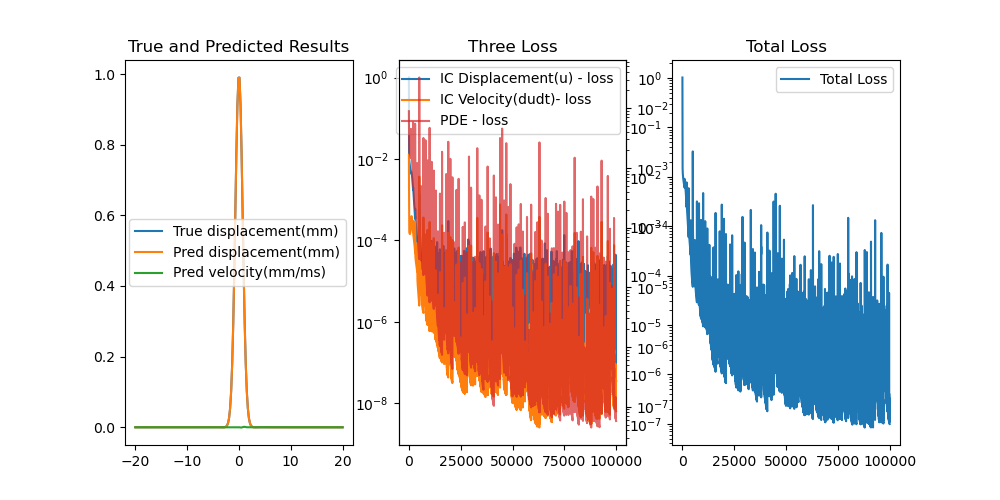

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
twinx_1 = axes[1].twinx()

x_ic = (
    torch.linspace(*x_range, ic_samples, device=device, dtype=torch.float)
    .view(-1, 1)
    .requires_grad_(True)
)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
net_ic_u = pinn(x_ic, t_ic)
net_dudt_ic = torch.autograd.grad(
    net_ic_u, t_ic, grad_outputs=torch.ones_like(net_ic_u), create_graph=True
)[0]
true_ic_u = A * torch.exp(-1 * (torch.linspace(*x_range, ic_samples) / SIGMA) ** 2)

axes[0].plot(
    np.linspace(*x_range, ic_samples),
    true_ic_u.cpu().detach(),
    label="True displacement(mm)",
)
axes[0].plot(
    np.linspace(*x_range, ic_samples),
    net_ic_u.cpu().detach(),
    label="Pred displacement(mm)",
)
axes[0].plot(
    np.linspace(*x_range, ic_samples),
    net_dudt_ic.cpu().detach(),
    label="Pred velocity(mm/ms)",
)
axes[0].legend()
axes[0].set_title("True and Predicted Results")

# Plotting Total Loss
total_loss = [
    losses[0][i] + losses[1][i] + losses[2][i]
    for i in range(min(len(losses[0]), len(losses[1]), len(losses[2])))
]
axes[2].plot(total_loss, label="Total Loss")
axes[2].set_yscale("log")
axes[2].legend()
axes[2].set_title("Total Loss")

ln1 = axes[1].plot(losses[0], label="IC Displacement(u) - loss")
ln2 = axes[1].plot(losses[1], label="IC Velocity(dudt)- loss")
axes[1].set_yscale("log")
ln4 = twinx_1.plot(losses[2], c="C3", alpha=0.7, label="PDE - loss")
twinx_1.set_yscale("log")

lns = ln1 + ln2 + ln4
labs = [l.get_label() for l in lns]
axes[1].legend(lns, labs, loc=0)
axes[1].set_title("Three Loss")

plt.show()
fig.savefig(os.path.join(folder_name, "Loss.png"))

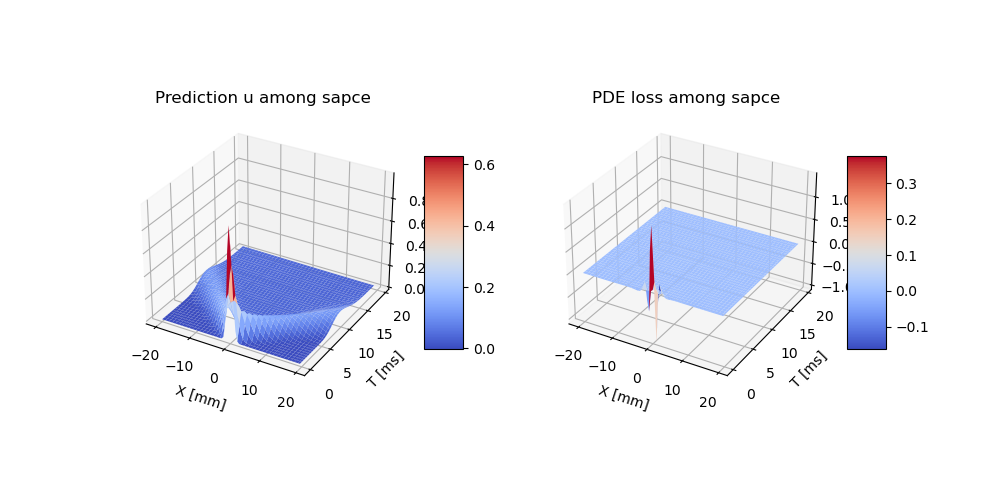

In [145]:
from matplotlib import cm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

x_test_range = [-20.0, 20.0]  # [mm]
t_test_range = [0.0, 20.0]  # [ms]


x = np.arange(*x_range, 0.5)
t = np.arange(*t_range, 0.5)
mg_x, mg_t = np.meshgrid(x, t, indexing='ij')

x_test = torch.from_numpy(mg_x.reshape((-1, 1))).float().to(device).requires_grad_(True)
t_test = torch.from_numpy(mg_t.reshape((-1, 1))).float().to(device).requires_grad_(True)

net_u = pinn(x_test, t_test).cpu()

pred_u_x = torch.autograd.grad(net_u, x_test, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
pred_u_t = torch.autograd.grad(net_u, t_test, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
pred_u_xx = torch.autograd.grad(pred_u_x, x_test, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
pred_u_tt = torch.autograd.grad(pred_u_t, t_test, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]
pred_u_xx_t = torch.autograd.grad(pred_u_xx, t_test, grad_outputs=torch.ones(net_u.size()), create_graph=True)[0]

# pde_loss = RHO*pred_u_tt - (RHO* CS**2 + ETA * pred_u_xx_t) * pred_u_xx
pde_loss = pred_u_tt - CS**2 * pred_u_xx - RATIO * pred_u_xx_t


net_u = net_u.detach().numpy().reshape(mg_x.shape)
pde_loss = pde_loss.detach().numpy().reshape(mg_x.shape)

surf = axes[0].plot_surface(mg_x, mg_t, net_u, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)

surf = axes[1].plot_surface(mg_x, mg_t, pde_loss, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)

axes[0].set(xlabel='X [mm]', ylabel='T [ms]')
axes[0].set_title('Prediction u among sapce ')

axes[1].set(xlabel='X [mm]', ylabel='T [ms]')
axes[1].set_title('PDE loss among sapce ')
plt.show()
fig.savefig(os.path.join(folder_name, 'Loss among space.png'))

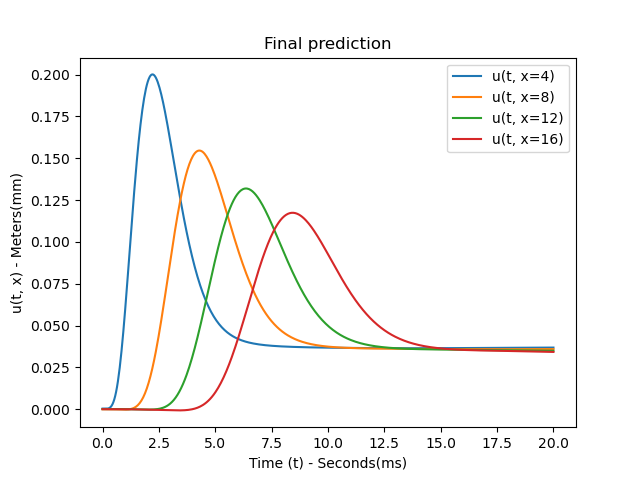

In [146]:
selected_x_values = [4, 8, 12, 16]
num_test_samples = 500

# Set the model to evaluation mode
pinn.eval()

# Create a single figure
fig, ax = plt.subplots()

# Plot u(t, x) for each selected x on the same graph
for selected_x in selected_x_values:
    # Predict u(t, x) distribution for the fixed x
    t_flat = np.linspace(0, 20, num_test_samples)
    x_flat = np.full_like(t_flat, fill_value=selected_x)
    tx = np.stack([t_flat, x_flat], axis=-1)

    # Convert to torch tensors
    x_tensor = torch.from_numpy(tx[:, 1]).float().view(-1, 1)
    t_tensor = torch.from_numpy(tx[:, 0]).float().view(-1, 1)

    # Forward pass
    u = pinn(x_tensor, t_tensor).detach()

    # Move predicted values to CPU for plotting
    u = u.cpu().numpy()

    # Plot the result
    ax.plot(t_flat, u, label=f'u(t, x={selected_x})')

ax.set_title('Final prediction')
ax.set_xlabel('Time (t) - Seconds(ms)')
ax.set_ylabel('u(t, x) - Meters(mm)')
ax.legend()
plt.show()
fig.savefig(os.path.join(folder_name, 'Prediction.png'))


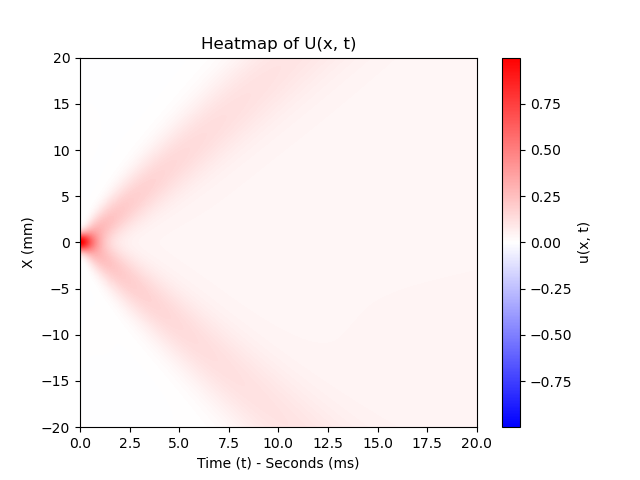

In [147]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define the ranges for time (t) and spatial position (x)
t_range = np.linspace(0, 20, num_test_samples)
x_range = np.linspace(-20, 20, num_test_samples)

# Create 2D meshgrid for time (t) and spatial position (x)
mg_t, mg_x = np.meshgrid(t_range, x_range)

# Convert meshgrid to torch tensors
t_tensor = torch.from_numpy(mg_t).float().view(-1, 1)
x_tensor = torch.from_numpy(mg_x).float().view(-1, 1)

# Forward pass to obtain u values
u = pinn(x_tensor, t_tensor).detach().cpu().numpy()

# Reshape u to match the shape of the meshgrid
u_2d = u.reshape(mg_t.shape)

# Create custom colormap
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # Blue to White to Red colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Create a new figure for the heatmap
fig, ax = plt.subplots()

# Plot the heatmap
im = ax.imshow(
    u_2d,
    extent=[np.min(t_range), np.max(t_range), np.min(x_range), np.max(x_range)],
    cmap=cmap,
    aspect="auto",
    origin="lower",
    norm=Normalize(vmin=-np.max(np.abs(u)), vmax=np.max(np.abs(u)))
)

# Set labels and title
ax.set_xlabel("Time (t) - Seconds (ms)")
ax.set_ylabel("X (mm)")
ax.set_title("Heatmap of U(x, t)")

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("u(x, t)")

plt.show()
fig.savefig(os.path.join(folder_name, "Heatmap of U.png"))


In [148]:
print("Shape of u_2d:", u_2d.shape)
print("Minimum value of u_2d:", np.min(u_2d))
print("Maximum value of u_2d:", np.max(u_2d))

Shape of u_2d: (500, 500)
Minimum value of u_2d: -0.00088823214
Maximum value of u_2d: 0.9982728


In [149]:


# Create a string with variable values
variables_content = f"A = {A}\nSIGMA = {SIGMA}\nCS = {CS}\nETA = {ETA}\nRHO = {RHO}\n\nRATIO = {RATIO}\nN_NEUROS = {N_NEUROS}\nTR_EPOCH = {TR_EPOCH}\n\nx_range = {x_range}\nt_range = {t_range}\nic_samples = {ic_samples}\nxt_samples = {xt_samples}\n\nepochs = {epochs}"

# Save the string to a text file
txt_file_path = os.path.join(folder_name, 'variables.txt')
with open(txt_file_path, 'w') as txt_file:
    txt_file.write(variables_content)

print(f"Variables saved to '{txt_file_path}'.")


Variables saved to 'c:\Users\Wayne\Desktop\CUDI-contrast-ultrasound dispersion imaging\16_weekly_update_25022024\2024-02-26_19-41\variables.txt'.
